In [43]:
import polars as pl
import matplotlib.pyplot as plt
import pathlib


In [44]:
ruta = pathlib.Path().parent.resolve()
data = f"{ruta}/data/sapal_salarios_clean.csv"


salarios_sapal =(
    pl.scan_csv(data)
)

df_filtrado = (
    salarios_sapal
    .select([
        pl.col("denominacion_del_cargo").alias("cargo"),
        pl.col("monto_mensual_bruto_de_la_remuneracion_en_tabulador").alias("salario_bruto_mensual")
    ])

)



df_cargos_unicos = (
    df_filtrado
    .select(
        pl.col("cargo")
    )
    .unique()
    .sort("cargo")
    .collect()
    .get_column("cargo")
    .to_list()
)


df_filtrado.collect()


cargo,salario_bruto_mensual
str,f64
"""SECRETARIA""",10416.6
"""PROGRAMADORA ANALISTA ""A""""",16699.0
"""SUP. CATASTRO FISICO INST.""",19532.3
"""AUX. ADMINISTRATIVA REDES""",12696.0
"""EJECUTIVA DEL SISTEMA DE ATENC…",15239.8
…,…
"""CHOFER DE TOLVA""",13921.1
"""CHOFER DE TOLVA""",13921.1
"""VIGILANTE DE POZOS""",13653.9


In [45]:


lf = (
    pl.scan_csv("data/sapal_salarios_clean.csv")
    .select([
        pl.col("denominacion_del_cargo").alias("cargo"),
        pl.col("monto_mensual_bruto_de_la_remuneracion_en_tabulador")
          .alias("salario_bruto_mensual"),
    ])
    .filter(
        pl.col("cargo").is_not_null() & (pl.col("cargo") != "")
    )
    .filter(
        pl.col("salario_bruto_mensual").is_not_null()
    )
)

lf_resumen_cargos = (
    lf
    .group_by("cargo")
    .agg([
        pl.len().alias("num_personas_en_cargo"),
        pl.col("salario_bruto_mensual").mean().alias("salario_bruto_promedio"),
        pl.col("salario_bruto_mensual").max().alias("salario_bruto_max"),
        pl.col("salario_bruto_mensual").sum().alias("costo_bruto_total_mensual_cargo"),
    ])
    .sort("salario_bruto_promedio", descending=True)
)

# ahora sí ejecutamos:
df_resumen_cargos = lf_resumen_cargos.collect()
df_resumen_cargos

cargo,num_personas_en_cargo,salario_bruto_promedio,salario_bruto_max,costo_bruto_total_mensual_cargo
str,u32,f64,f64,f64
"""DIRECTOR GENERAL""",1,141667.3,141667.3,141667.3
"""SUBDIRECTOR GENERAL OPERATIVO""",1,101905.4,101905.4,101905.4
"""SUBDIRECTORA DE PLANEACION""",1,90119.6,90119.6,90119.6
"""GERENTE COMERCIAL""",1,86502.0,86502.0,86502.0
"""PROSECRETARIO""",1,86502.0,86502.0,86502.0
…,…,…,…,…
"""PEON FISCALIZACION ECOLOGICA""",4,9800.0,9800.0,39200.0
"""PEON LABORATORIO""",2,9800.0,9800.0,19600.0
"""PEON ALCANTARILLADO""",24,9800.0,9800.0,235200.0


In [46]:
print(f"Total de trabajadores: {df_resumen_cargos['num_personas_en_cargo'].sum()}")

Total de trabajadores: 1605


In [47]:


lista_cargos_importantes = [
    'DIRECTOR GENERAL',
    'JEFE DE SISTEMAS COMPUTACIONALES',
    'GERENTE COMERCIAL',
    'GERENTE DE CALIDAD DEL AGUA Y FISCALIZACION',
    'GERENTE DE SUPERVISION DE OBRA',
    'JEFE DE PROYECTOS',
    'GERENTE DE FINANZAS',
    'GERENTE DE PROYECTOS Y COSTOS',
    'SUBDIRECTORA DE PLANEACION',
    'ADMINISTRADOR DE REDES Y COMUNICACIONES',
    'GERENTE DE AGUA POTABLE Y ALCANTARILLADO',
    'PROGRAMADORA ANALISTA "A"',
    'PROGRAMADOR ANALISTA"B"',
    'PROGRAMADOR ANALISTA',
    'PROGRAMADORA ANALISTA',
    'JEFE DE TECNOLOGIAS DE LA OPERACION',
    'SUBDIRECTOR GENERAL OPERATIVO',
    'JEFE DE PLANEACION HIDRICA',
    'JEFE DE COMUNICACION',
    'JEFE DE COSTOS Y EVALUACION',
    'GERENTE DE TECNOLOGIAS DE LA INFORMACION Y COMUNICACION',
    'GERENTE SERVICIOS ADMINISTRATIVOS'
]


cargo_encontrados = []

for cargo in df_cargos_unicos:
    if cargo  in lista_cargos_importantes:
        cargo_encontrados.append(cargo)
if len(cargo_encontrados) == len(lista_cargos_importantes):
    print(f"Se encontraron todos los cargos importantes: {len(lista_cargos_importantes)}/{len(cargo_encontrados)}")



Se encontraron todos los cargos importantes: 22/22


In [48]:
df_trabajadores_de_interes = (
    df_filtrado
    .filter(
        pl.col("cargo").is_in(cargo_encontrados)
    )
    .sort("salario_bruto_mensual", descending=True)
    .collect()
)



In [49]:
df_trabajadores_de_interes.shape

(30, 2)

In [50]:
for cargo,sueldo in zip(
    df_trabajadores_de_interes["cargo"],
    df_trabajadores_de_interes["salario_bruto_mensual"]
):
    print(f"{cargo:>60}: ${sueldo:,.0f}")


                                            DIRECTOR GENERAL: $141,667
                               SUBDIRECTOR GENERAL OPERATIVO: $101,905
                                  SUBDIRECTORA DE PLANEACION: $90,120
                                           GERENTE COMERCIAL: $86,502
                 GERENTE DE CALIDAD DEL AGUA Y FISCALIZACION: $76,961
                              GERENTE DE SUPERVISION DE OBRA: $76,961
                                         GERENTE DE FINANZAS: $76,961
                               GERENTE DE PROYECTOS Y COSTOS: $76,961
                    GERENTE DE AGUA POTABLE Y ALCANTARILLADO: $76,961
     GERENTE DE TECNOLOGIAS DE LA INFORMACION Y COMUNICACION: $76,961
                           GERENTE SERVICIOS ADMINISTRATIVOS: $76,961
                                        JEFE DE COMUNICACION: $75,488
                            JEFE DE SISTEMAS COMPUTACIONALES: $50,493
                                           JEFE DE PROYECTOS: $50,493
                  

In [51]:
df = df_trabajadores_de_interes.clone()


df = df.with_columns([
    (pl.col("salario_bruto_mensual") / 4.33).alias("sueldo_semanal"),
    (pl.col("salario_bruto_mensual") / 4.33 / 48).alias("sueldo_hora"),
])






def estimador_costo_decisiones_por_mes(df: pl.DataFrame,horas_dedicadas: int = 72) -> float:
    """
    Arguments:
        df: DataFrame con columna "sueldo_hora"
        horas_dedicadas: Horas totales dedicadas por el equipo en toma de decisiones por mes
    Returns:
        Costo total mensual del tiempo dedicado a toma de decisiones por el equipo 
    """
    sueldo_hora_del_equipo = df["sueldo_hora"].sum()
    costo_tiempo_decision_mes = sueldo_hora_del_equipo * horas_dedicadas # "horas_dedicadas" es a 72 horas/mes
    return costo_tiempo_decision_mes


def estimador_costo_decisiones_por_años(df: pl.DataFrame, horas_dedicadas: int = 72, años: int = 1) -> float:
    """
    Arguments:
        df: DataFrame con columna "sueldo_hora"
        horas_dedicadas: Horas totales dedicadas por el equipo en toma de decisiones por mes
    Returns:
        Costo total anual del tiempo dedicado a toma de decisiones por el equipo
    """
    costo_tiempo_decision_mes = estimador_costo_decisiones_por_mes(df, horas_dedicadas)
    costo_tiempo_decision_anual = costo_tiempo_decision_mes * 12 * años
    return costo_tiempo_decision_anual


HORAS_AL_MES = 72
num_años = 5
costo_mensual = estimador_costo_decisiones_por_mes(df, horas_dedicadas=HORAS_AL_MES)
costo_anual = estimador_costo_decisiones_por_años(df, horas_dedicadas=HORAS_AL_MES, años=num_años)




print(f"{"="*40} Datos de salarios y costos por hora {"="*40}")
#print(df)

print(f"Costo en la toma de decisiones dedicandole {HORAS_AL_MES} horas al mes:")
print(f"- Costo mensual: ${costo_mensual:,.0f}")
print(f'- Costo anualizado con una proyección a "{num_años}" año(s): ${costo_anual:,.0f}')


======================================== Datos de salarios y costos por hora ========================================
Costo en la toma de decisiones dedicandole 72 horas al mes:
- Costo mensual: $538,113
- Costo anualizado con una proyección a "5" año(s): $32,286,787


/var/folders/j4/21ypxx3x0019wgj7rqnlm2340000gn/T/ipykernel_76150/1121567861.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


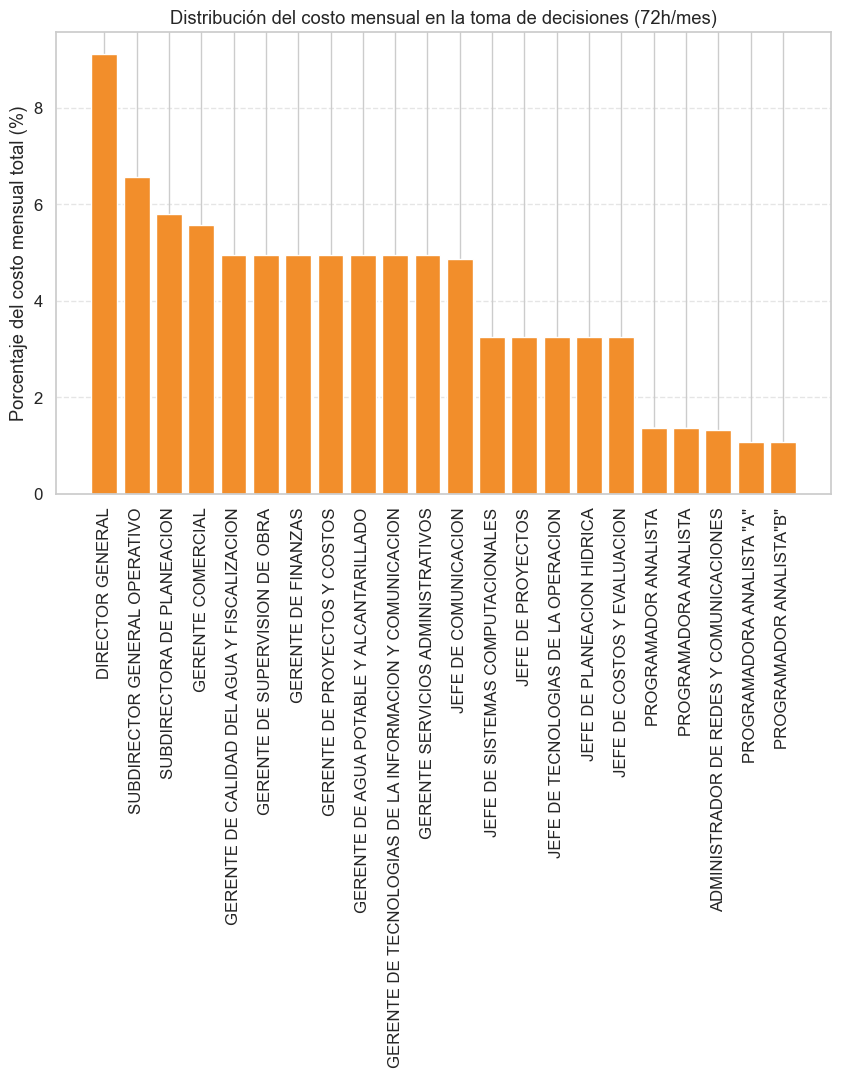

In [52]:
# Calcular participación de cada cargo en el costo mensual total
df_prop = df.with_columns(
    ((pl.col("sueldo_hora") * HORAS_AL_MES) / costo_mensual * 100).alias("porcentaje_participacion")
).sort("porcentaje_participacion", descending=True).to_pandas()

plt.figure(figsize=(10, 6))
plt.bar(df_prop["cargo"], df_prop["porcentaje_participacion"], color="#F28E2B")
plt.xticks(rotation=90)
plt.ylabel("Porcentaje del costo mensual total (%)")
plt.title(f"Distribución del costo mensual en la toma de decisiones ({HORAS_AL_MES}h/mes)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
#plt.show()

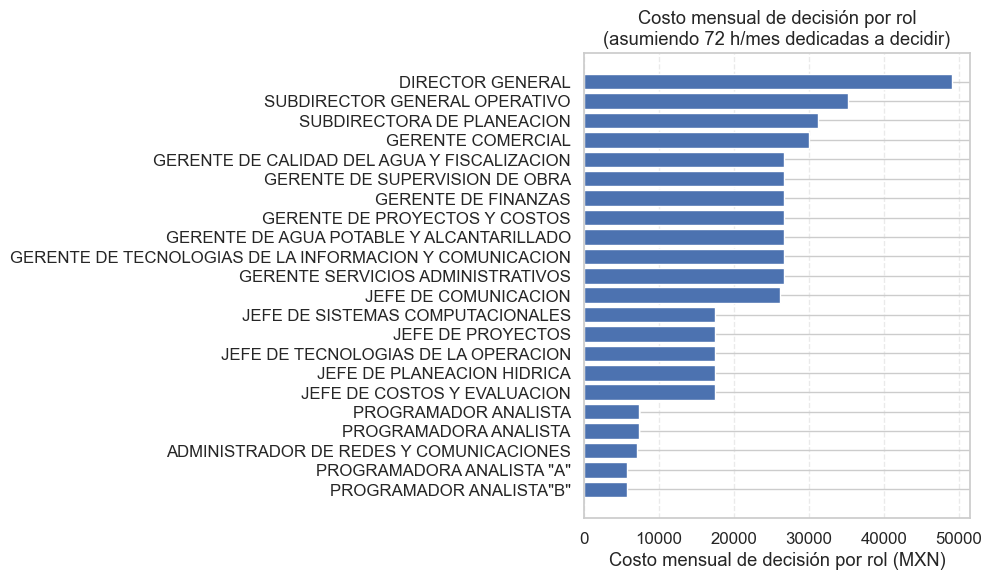

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# calculamos el costo mensual atribuible a cada cargo
# costo_mensual_individual = sueldo_hora * HORAS_AL_MES
df_costo_roles = df.with_columns([
    (pl.col("sueldo_hora") * HORAS_AL_MES).alias("costo_mensual_rol")
]).select([
    "cargo",
    "costo_mensual_rol"
]).sort("costo_mensual_rol", descending=True).to_pandas()

plt.figure(figsize=(10,6))
plt.barh(df_costo_roles["cargo"], df_costo_roles["costo_mensual_rol"])
plt.xlabel("Costo mensual de decisión por rol (MXN)")
plt.title(f"Costo mensual de decisión por rol\n(asumiendo {HORAS_AL_MES} h/mes dedicadas a decidir)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
#plt.show()

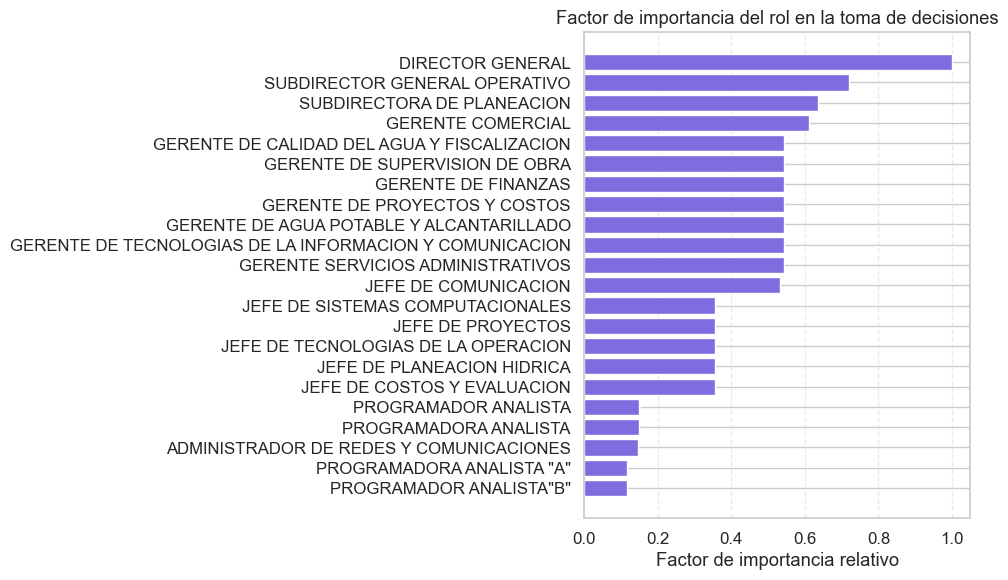

In [54]:
import matplotlib.pyplot as plt

# Calculamos el costo mensual por rol (ya en MXN)
df_factor = df.with_columns([
    (pl.col("sueldo_hora") * HORAS_AL_MES).alias("costo_mensual_rol")
]).sort("costo_mensual_rol", descending=True).to_pandas()

# Factor relativo respecto al más alto (Director General)
df_factor["factor_importancia"] = df_factor["costo_mensual_rol"] / df_factor["costo_mensual_rol"].max()

plt.figure(figsize=(10,6))
plt.barh(df_factor["cargo"], df_factor["factor_importancia"], color="#7D6DDF")
plt.xlabel("Factor de importancia relativo")
plt.title("Factor de importancia del rol en la toma de decisiones")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
#plt.show()

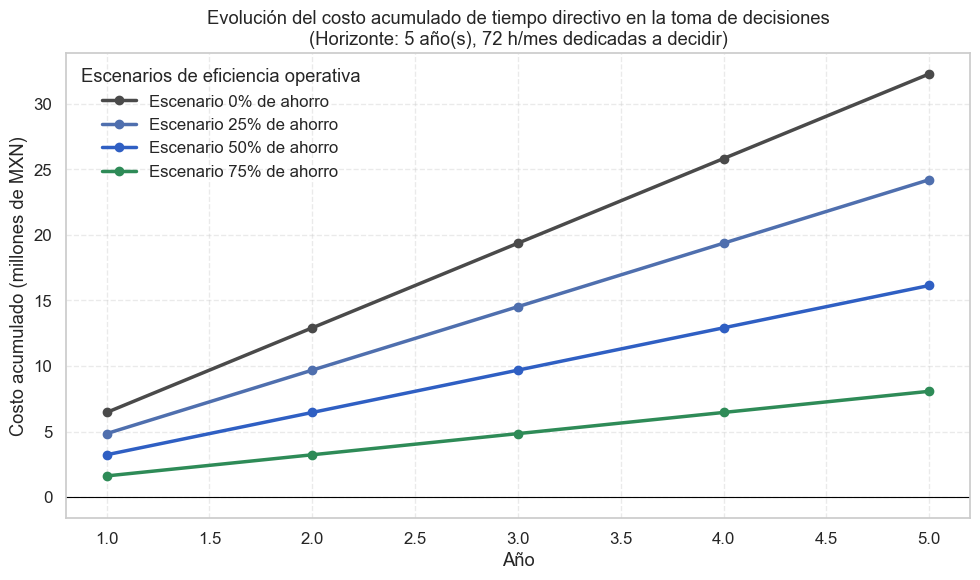

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# === Datos base ===
# Partimos de tus variables actuales
costo_anual_base = estimador_costo_decisiones_por_años(
    df, horas_dedicadas=HORAS_AL_MES, años=1
)

anios = np.arange(1, num_años + 1)

# === Escenarios de ahorro ===
escenarios = {
    "Escenario 0% de ahorro": costo_anual_base * anios,           # Peor caso
    "Escenario 25% de ahorro": costo_anual_base * 0.75 * anios,   # Ahorro leve
    "Escenario 50% de ahorro": costo_anual_base * 0.50 * anios,   # Ahorro medio
    "Escenario 75% de ahorro": costo_anual_base * 0.25 * anios,   # Ahorro alto
}

# === Colores manuales coherentes con los escenarios ===
colores = {
    "Escenario 0% de ahorro":   "#4A4A4A",  # gris oscuro = nada mejora, seguimos quemando
    "Escenario 25% de ahorro":  "#4F6FAE",  # azul sobrio / control financiero inicial
    "Escenario 50% de ahorro":  "#2F5FC3",  # azul más intenso / eficiencia clara
    "Escenario 75% de ahorro":  "#2E8B57",  # verde (tipo verde bosque) / retorno fuerte
}

# === Gráfico ===
plt.figure(figsize=(10, 6))

for label, valores in escenarios.items():
    plt.plot(
        anios,
        valores / 1e6,  # en millones
        marker="o",
        linewidth=2.5,
        color=colores[label],
        label=label
    )

plt.title(
    f"Evolución del costo acumulado de tiempo directivo en la toma de decisiones\n"
    f"(Horizonte: {num_años} año(s), {HORAS_AL_MES} h/mes dedicadas a decidir)"
)
plt.xlabel("Año")
plt.ylabel("Costo acumulado (millones de MXN)")

# === Ajustes visuales ===
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(
    title="Escenarios de eficiencia operativa",
    frameon=False,
    loc="upper left"
)

# Resaltamos visualmente el eje 0
plt.axhline(y=0, color="black", linewidth=0.8)

plt.tight_layout()
#plt.show()

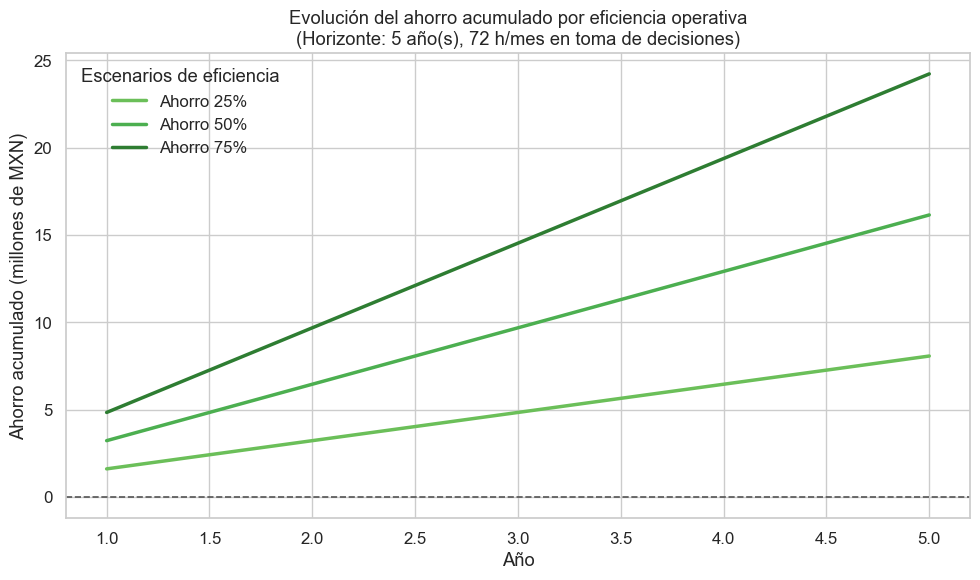

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# ==============================
# Cálculos base (tus funciones)
# ==============================
costo_anual_base = estimador_costo_decisiones_por_años(df, horas_dedicadas=HORAS_AL_MES, años=1)
anios = np.arange(1, num_años + 1)

# Escenarios de ahorro (en millones MXN)
escenarios = {
    "Ahorro 25%": costo_anual_base * (1 - 0.25) * anios,
    "Ahorro 50%": costo_anual_base * (1 - 0.50) * anios,
    "Ahorro 75%": costo_anual_base * (1 - 0.75) * anios,
}

# Costo sin ahorro (referencia)
costo_sin_ahorro = costo_anual_base * anios

# Calcular ahorro acumulado = costo sin ahorro - costo con ahorro
data = []
for label, valores in escenarios.items():
    ahorro = (costo_sin_ahorro - valores) / 1e6  # millones de MXN
    for año, val in zip(anios, ahorro):
        data.append({"Año": año, "Ahorro (millones MXN)": val, "Escenario": label})

df_plot = pd.DataFrame(data)

# ==============================
# Visualización con Seaborn
# ==============================
sns.set_theme(style="whitegrid", font_scale=1.1)
palette = {
    "Ahorro 25%": "#6BBF59",  # verde medio
    "Ahorro 50%": "#4CAF50",  # verde principal
    "Ahorro 75%": "#2E7D32",  # verde oscuro
}

plt.figure(figsize=(10, 6))

# Curvas suavizadas
for esc in df_plot["Escenario"].unique():
    subset = df_plot[df_plot["Escenario"] == esc]
    x_smooth = np.linspace(subset["Año"].min(), subset["Año"].max(), 200)
    spline = make_interp_spline(subset["Año"], subset["Ahorro (millones MXN)"], k=2)
    y_smooth = spline(x_smooth)
    plt.plot(
        x_smooth, y_smooth,
        label=esc,
        color=palette[esc],
        linewidth=2.5
    )

# Línea base (sin ahorro)
plt.axhline(0, color="#555", linewidth=1.2, linestyle="--")

plt.title(
    f"Evolución del ahorro acumulado por eficiencia operativa\n"
    f"(Horizonte: {num_años} año(s), {HORAS_AL_MES} h/mes en toma de decisiones)"
)
plt.xlabel("Año")
plt.ylabel("Ahorro acumulado (millones de MXN)")
plt.legend(title="Escenarios de eficiencia", frameon=False, loc="upper left")
plt.tight_layout()
plt.show()